# Reconstruction - spherical model
---

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch
import copy

from astropy     import units, constants
from pomme.model import TensorModel, SphericalModel
from pomme.loss  import Loss, diff_loss
from pomme.plot  import plot_cube_2D
from pomme.utils import planck, T_CMB

from spherical import lines, velocities, frequencies, smodel, r_out, get_velocity, get_temperature, get_abundance, get_turbulence, get_boundary_condition
from spherical import smodel as smodel_truth

/STER/frederikd/pomme/docs/src/examples/spherical/spherical.py:46: RuntimeWarning: divide by zero encountered in true_divide
  rho  = Mdot / (4.0 * np.pi * rs**2 * v)
/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


You have selected line:
    CO(J=3-2)
Please check the properties that were inferred:
    Frequency         3.457959899e+11  Hz
    Einstein A coeff  2.497000000e-06  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    CO(J=7-6)
Please check the properties that were inferred:
    Frequency         8.066518060e+11  Hz
    Einstein A coeff  3.422000000e-05  1/s
    Molar mass        28.0101          g/mol


In [2]:
obss = torch.load('obss.pt')

In [22]:
smodel = SphericalModel(
    rs       = smodel_truth.rs,
    model_1D = TensorModel.load('model_truth.h5'),
    r_star   = smodel_truth.r_star,
)
smodel.get_abundance          = get_abundance
smodel.get_velocity           = get_velocity
smodel.get_temperature        = get_temperature
smodel.get_turbulence         = get_turbulence
smodel.get_boundary_condition = get_boundary_condition

log_n_CO_init = np.log(5.0e+14*(smodel.rs.min()/smodel.rs)**2)

smodel.model_1D['log_CO'] = log_n_CO_init.copy()
# smodel.model_1D.free(['log_CO', 'log_v_in', 'log_v_inf', 'log_beta', 'log_T_in', 'log_epsilon'])
smodel.model_1D.free(['log_CO'])

losses = Loss(['avg', 'rel', 'reg', 'cnt'])

In [23]:
smodel.model_1D.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_CO                     Free          True     +1.082e+01     +2.233e+01     +3.385e+01
  log_R_star                 Fixed         False    +2.573e+01     +2.573e+01     +2.573e+01
  log_T_in                   Fixed         False    +7.824e+00     +7.824e+00     +7.824e+00
  log_T_star                 Fixed         False    +7.824e+00     +7.824e+00     +7.824e+00
  log_beta                   Fixed         False    -6.931e-01     -6.931e-01     -6.931e-01
  log_epsilon                Fixed         False    -5.108e-01     -5.108e-01     -5.108e-01
  log_r                      Fixed         True     +2.343e+01     +2.919e+01     +3.494e+01
  log_turbulence             Fixed         True     +6.908e+00     +6.908e+00     +6.908e+00
  log_v_in                   Fixed         False    +4.605e+00     +4.605e+00     +4.605e+00
  log_v_inf                  Fixed         False    +9.903e+00     +9.903e+00

In [24]:
imgs = smodel.image(lines, frequencies, r_max=r_out)

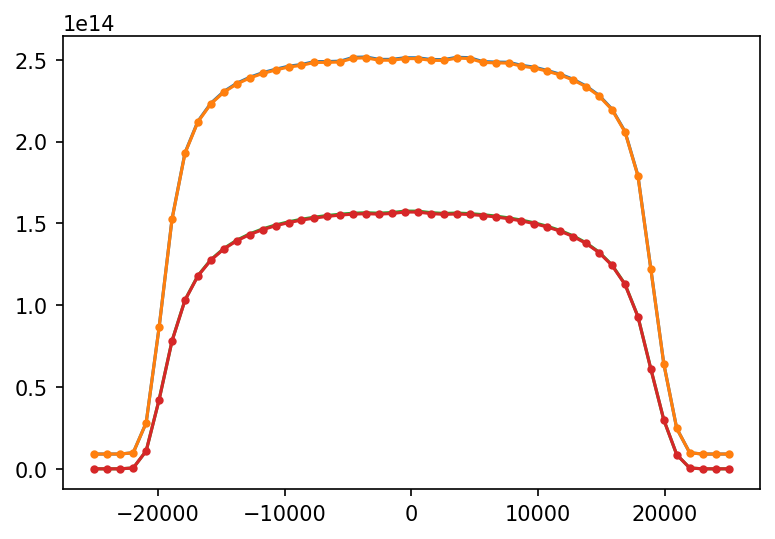

In [25]:
plt.figure(dpi=150)
for obs, img in zip(obss, imgs):
    plt.plot(velocities, obs.data)
    plt.plot(velocities, img.data, marker='.')

In [26]:
def steady_state_cont_loss(smodel):
    """
    Loss assuming steady state hydrodynamics, i.e. vanishing time derivatives.
    """
    # Get a mask for the elements outsife the star
    outside_star = torch.from_numpy(smodel.rs) > torch.exp(smodel.model_1D['log_R_star'])
        
    # Get the model variables
    rho = smodel.get_abundance(smodel.model_1D)[outside_star]
    v_r = smodel.get_velocity (smodel.model_1D)[outside_star]
    r   = torch.from_numpy(smodel.rs)          [outside_star]

    # Continuity equation (steady state): div(ρ v) = 0
    loss_cont = smodel.diff_r(r**2 * rho * v_r, r)

    # Compute the mean squared losses
    loss = torch.mean((loss_cont/((r**2)*rho))**2)
    # Return losses
    return loss

In [27]:
from torch.optim import Adam
from tqdm        import tqdm

obss_avg = obss.mean(axis=1)
obss_rel = torch.einsum("ij, i -> ij", obss, 1.0 / obss.mean(axis=1))

# Get a mask for the elements outsife the star
outside_star = torch.from_numpy(smodel.rs) > torch.exp(smodel.model_1D['log_R_star'])
        

def fit(losses, smodel, lines, frequencies, obss, N_epochs=10, lr=1.0e-1, w_avg=1.0, w_rel=1.0, w_reg=1.0, w_cnt=1.0):

    params = [
        smodel.model_1D['log_CO'],
        # smodel.model_1D['log_v_in'],
        # smodel.model_1D['log_v_inf'],
        # smodel.model_1D['log_beta'],
        # smodel.model_1D['log_T_in'],
        # smodel.model_1D['log_epsilon'],
    ]

    abundance_evol = [smodel.get_abundance(smodel.model_1D).detach().clone()]
    
    optimizer = Adam(params, lr=lr)

    for _ in tqdm(range(N_epochs)):

        # Forward model
        imgs = smodel.image(lines, frequencies, r_max=r_out)

        imgs_avg= imgs.mean(axis=1)
        imgs_rel= torch.einsum("ij, i -> ij", imgs, 1.0 / imgs.mean(axis=1))

        # Compute the reproduction loss
        losses['avg'] = w_avg * torch.nn.functional.mse_loss(imgs_avg, obss_avg)
        losses['rel'] = w_rel * torch.nn.functional.mse_loss(imgs_rel, obss_rel)
        # Compute the regularisation loss
        losses['reg'] = w_reg * diff_loss(smodel.model_1D['log_CO'][outside_star])
        # Compute the hydrodynamic loss   
        losses['cnt'] = w_cnt * steady_state_cont_loss(smodel)   

        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        losses.tot().backward()
        # Update parameters
        optimizer.step()

        abundance_evol.append(smodel.get_abundance(smodel.model_1D).detach().clone())

    return imgs, losses, abundance_evol

In [28]:
imgs, losses, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=3, lr=1.0e-1, w_avg=1.0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

losses.renormalise_all()
losses.reset()

  0%|          | 0/3 [00:00<?, ?it/s]/home/frederikd/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 3/3 [00:22<00:00,  7.40s/it]


In [29]:
imgs, loss, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=10, lr=1.0e-1, w_avg=1.0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

100%|██████████| 10/10 [01:11<00:00,  7.14s/it]


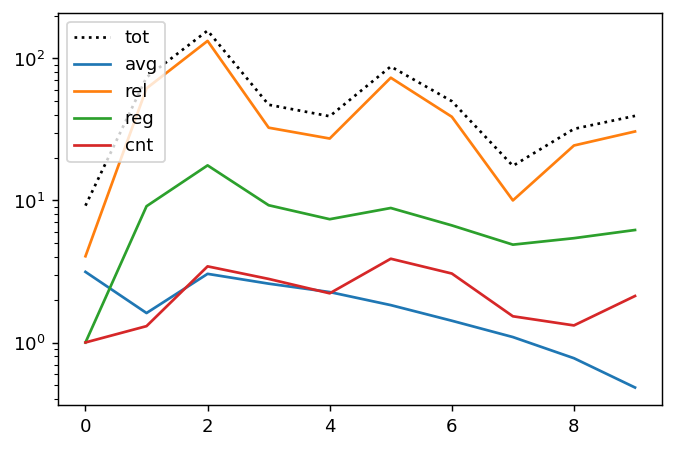

In [30]:
losses.plot()

In [31]:
imgs, loss, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=500, lr=1.0e-1, w_avg=1.0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

 47%|████▋     | 235/500 [1:25:33<1:48:03, 24.47s/it]

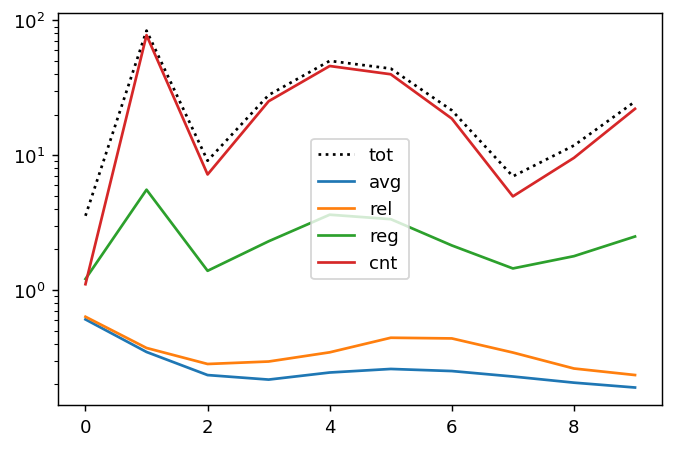

In [ ]:
losses.plot()

In [12]:
imgs, loss, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=500, lr=1.0e-1, w_avg=1.0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

100%|██████████| 200/200 [06:26<00:00,  1.93s/it]


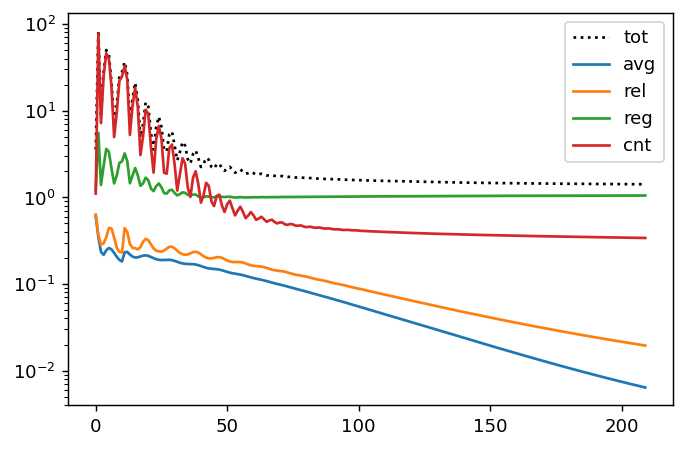

In [14]:
loss.plot()

In [15]:
imgs, loss, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=250, lr=1.0e-1, w_avg=1.0e+2, w_rel=1.0e+2, w_reg=1.0e-0, w_cnt=1.0e+0)

100%|██████████| 250/250 [07:53<00:00,  1.89s/it]


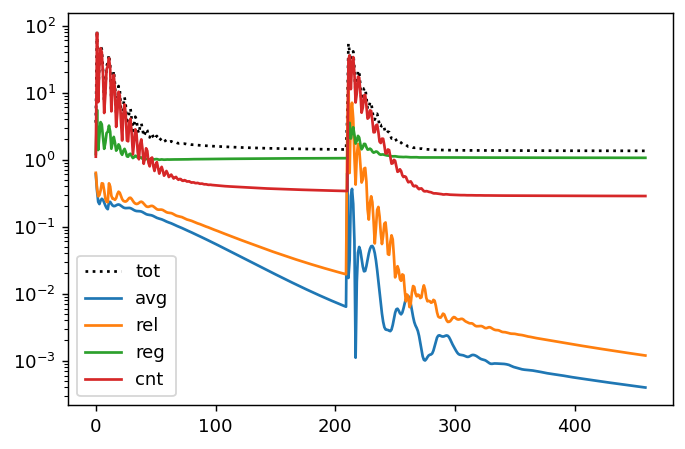

In [18]:
loss.plot()

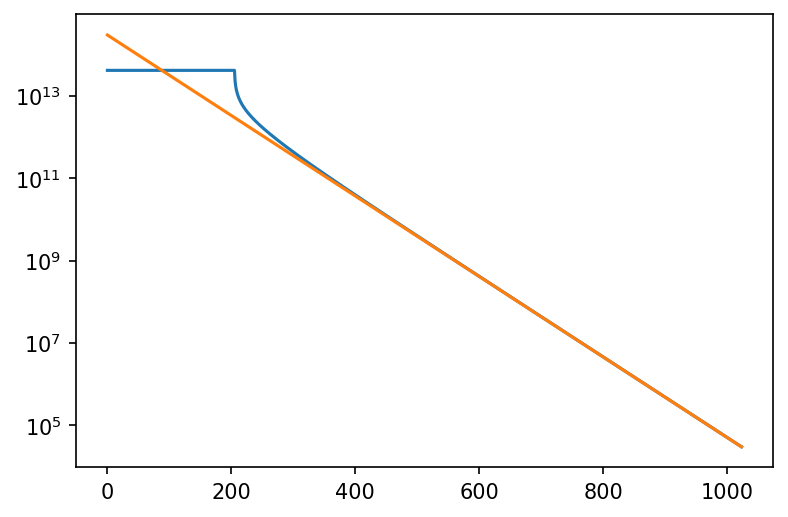

In [21]:
plt.figure(dpi=150)
# for CO in a_evol[:]:
    # plt.plot(CO)
plt.plot(torch.exp(smodel_truth.model_1D['log_CO']).data)
plt.plot(np.exp(log_n_CO_init))
plt.yscale('log')